In [54]:
import os
# !pip install unrar
# !unrar x '/content/drive/MyDrive/Fatepura_satellite_dataset_800_altitude/800_dataset_with_semantic_segmentation.rar'

In [55]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
import os
import random
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.style.use("ggplot") # 這行程式碼設置了 matplotlib 的繪圖風格。

# 這是 Jupyter Notebook 的魔法命令，它用於指定 matplotlib 繪圖的輸出方式。
# 可以直接在 Notebook 中看到圖形，而不需要使用 plt.show()。
%matplotlib inline 
import gc

from tqdm.notebook import trange, tqdm

from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Conv2D, Input, MaxPooling2D, Dropout, concatenate, UpSampling2D
from keras.models import load_model, Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras import backend as K

from keras.layers import *
from keras.optimizers import *
from keras.models import *
from keras.preprocessing.image import *
from keras.callbacks import *

from keras.utils import plot_model

import random 

## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [2]:
w, h = 640, 640
border = 5 

In [3]:
ids = next(os.walk("dataset/train/Images"))[2] # list of names all images in the given path
print(ids)
print("No. of images = ", len(ids))

['11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg', '41.jpg']
No. of images =  6


# **Data Reading and Train test split**

In [59]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
import glob
train = sorted(glob.glob("dataset/train/Images/*"))
train_mask = sorted(glob.glob("dataset/train/Mask/*.png"))[:64]
print(f'Total Train Images : {len(train)}\nTotal Mask Image : {len(train_mask)}')

Total Train Images : 6
Total Mask Image : 6


In [6]:
X = np.zeros((len(train), h, w, 1), dtype=np.float32)
y = np.zeros((len(train_mask), h, w, 1), dtype=np.float32)
X_name = []

In [7]:
for n, (img, mimg) in (enumerate(zip(train, train_mask))):
  print(n, img, mimg)
  X_name.append(img)

  # Load images
  img = load_img(img, color_mode = "grayscale")
  x_img = img_to_array(img)
  x_img = resize(x_img, (h, w, 1), mode = 'constant', preserve_range = True)

  # Load masks
  mask = img_to_array(load_img(mimg, color_mode = "grayscale"))
  mask = resize(mask, (h, w, 1), mode = 'constant', preserve_range = True)
  
  # Save images
  X[n] = x_img/255
  y[n] = mask/255

0 dataset/train/Images\11.jpg dataset/train/Mask\11.png
1 dataset/train/Images\12.jpg dataset/train/Mask\12.png
2 dataset/train/Images\13.jpg dataset/train/Mask\13.png
3 dataset/train/Images\14.jpg dataset/train/Mask\14.png
4 dataset/train/Images\15.jpg dataset/train/Mask\15.png
5 dataset/train/Images\41.jpg dataset/train/Mask\41.png


In [8]:
if not os.path.exists("x_y_npy"):
    os.makedirs("x_y_npy")

# Save the files in Numpy array for reusability
np.save('x_y_npy/x.npy', X)
np.save('x_y_npy/y.npy', y)
print(X.shape, y.shape)
X = np.load('x_y_npy/x.npy')
y = np.load('x_y_npy/y.npy')
print(X.shape, y.shape)
print(X_name)

(6, 640, 640, 1) (6, 640, 640, 1)
(6, 640, 640, 1) (6, 640, 640, 1)
['dataset/train/Images\\11.jpg', 'dataset/train/Images\\12.jpg', 'dataset/train/Images\\13.jpg', 'dataset/train/Images\\14.jpg', 'dataset/train/Images\\15.jpg', 'dataset/train/Images\\41.jpg']


In [9]:
# Split train and valid
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
gc.collect() #  用於清理不再使用的對象，釋放內存。

(4, 640, 640, 1) (4, 640, 640, 1) (2, 640, 640, 1) (2, 640, 640, 1)


22

# **Visualization the image and It masks**

1. X_train[idx, ..., 0] = X_train[idx, :, :, 0]

2. 現在讓我們解釋一下 squeeze() 的作用。在 NumPy 中，squeeze() 函數用於刪除大小為 1 的維度。在這種情況下，y_train[ix] 的形狀可能是 (640, 640, 1)，其中最後一個維度是 1。squeeze() 的作用是將這個大小為 1 的維度擠壓掉，使得遮罩的形狀變為 (640, 640)，這是 contour 函數期望的形狀。https://steam.oxxostudio.tw/category/python/example/matplotlib-contour.html
3. 它指定輪廓線應該在哪些值處繪製。如果省略此參數，contour 函數將自動選擇一組適合的值。

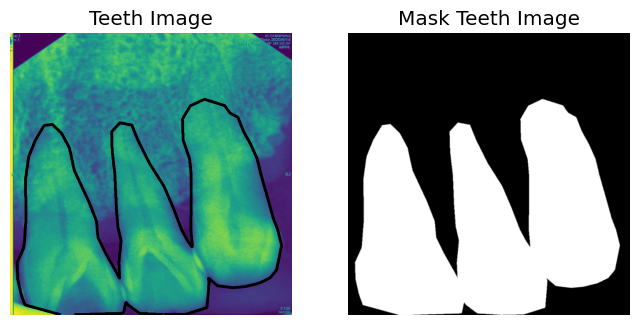

In [10]:
# Visualize any randome image along with the mask
idx = random.randint(0, len(X_train)-1)
has_mask = y_train[idx].max() > 0 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8, 8))

ax1.imshow(X_train[idx, ..., 0], interpolation = 'bilinear')
if has_mask:
    ax1.contour(y_train[idx].squeeze(), colors = 'k', linewidths = 2, levels = [0.5])
ax1.set_title('Teeth Image')
ax1.set_axis_off() # 不顯示 x, y 軸線

ax2.imshow(y_train[idx].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Mask Teeth Image')
ax2.set_axis_off() # 不顯示 x, y 軸線

## Build DenseUnet

1. `清理 Keras Session` : 這一部分的目的是清理先前 Keras 會話中的任何模型，變數或計算圖。這有助於釋放資源並確保你在定義新模型之前的狀態是乾淨的。
2. `建立模型` : input_shape 參數指定了模型的輸入形狀，nClasses 指定了輸出的標籤數量，這裡是 1，可能是二元分類的情況。
3. `3. 定義評估指標（Metrics）`: 定義了一組評估指標（metrics）包括準確度（accuracy）、AUC、在特定特異度（Specificity）下的敏感度（Sensitivity）和在特定敏感度下的特異度。這些指標將在模型訓練過程中被計算。
4. `編譯模型` : 指定優化器（optimizer）為 Adam，損失函數（loss function）為二元交叉熵（binary_crossentropy），並指定了之前定義的評估指標列表。
5. `清理資源` : 最後一行使用 gc.collect() 進行垃圾回收，釋放不再使用的資源。

In [11]:
from keras import backend as K
from model.DenseUnet import DenseUNet
K.clear_session()

# input_img = Input((h, w, 1), name='img')
# del model
model = DenseUNet(nClasses=1, input_height=h, input_width=w)
gc.collect()

830

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 640, 640, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 640, 640, 16)         160       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 640, 640, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 640, 640, 16)         0         ['batch_normalization[0][0

* tf.keras.utils.plot_model 函數繪製模型結構。該函數的參數說明如下：
1. `model`: 要繪製的 Keras 模型。
2. `to_file`: 指定保存圖像的文件名。
3. `show_shapes`: 如果為 True，將顯示每個層的輸入/輸出形狀。
4. `show_layer_names`: 如果為 True，將顯示每個層的名稱。
* https://blog.csdn.net/L_cherry_/article/details/122111303

In [68]:
# plot_model(model, to_file='model/DenseUnet.png', show_shapes=True, show_layer_names=True)

* verbose=0：不輸出任何信息。
* verbose=1：輸出一些基本信息，例如進度條等。
* verbose=2：輸出更詳細的信息。
* `TensorBoard` : 開啟 cmd/終端機，執行 tensorboard --logdir=.\logs，啟動網頁伺服器，再使用瀏覽器輸入以下網址，即可觀看訓練資訊：
http://localhost:6006/
* Keras Callback 的使用 : https://ithelp.ithome.com.tw/articles/10234641?sc=pt

In [13]:

callbacks = [
    EarlyStopping(patience=15, monitor='val_loss', verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=7, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model/model-DenseUnet.h5', verbose=1, save_best_only=True, save_weights_only=True),
    CSVLogger("result/data_DenseUnet.csv"),
    TensorBoard(log_dir='./logs')
]
# >> tensorboard --logdir=path/to/logs

In [14]:
# 載入最近的檢查點的權重
# model.load_weights('model/model-UnetPP.h5') # change 
results = model.fit(X_train, y_train, batch_size=1, epochs=15, callbacks=callbacks, validation_data=(X_test, y_test), use_multiprocessing=True)


Epoch 1/15


4/4 [==============================] - ETA: 0s - loss: 0.7184 - accuracy: 0.3276 - mean_io_u: 1.0000 - auc: 0.4761 - precision: 0.3495 - recall: 0.4161 - sensitivity_at_specificity: 0.4493 - specificity_at_sensitivity: 0.4505
Epoch 1: val_loss improved from inf to 0.69213, saving model to model\model-DenseUnet.h5
4/4 [==============================] - 40s 3s/step - loss: 0.7184 - accuracy: 0.3276 - mean_io_u: 1.0000 - auc: 0.4761 - precision: 0.3495 - recall: 0.4161 - sensitivity_at_specificity: 0.4493 - specificity_at_sensitivity: 0.4505 - val_loss: 0.6921 - val_accuracy: 0.3386 - val_mean_io_u: 1.0000 - val_auc: 0.5687 - val_precision: 0.5662 - val_recall: 0.4889 - val_sensitivity_at_specificity: 0.3292 - val_specificity_at_sensitivity: 0.3393 - lr: 0.0010
Epoch 2/15
4/4 [==============================] - ETA: 0s - loss: 0.5903 - accuracy: 0.4431 - mean_io_u: 1.0000 - auc: 0.7381 - precision: 0.5680 - recall: 0.6175 - sensitivity_at_specificity: 0.8285 - specificity_at_s

In [15]:
df_result = pd.DataFrame(results.history)
df_result.sort_values('val_loss', ascending=True, inplace = True)
df_result

,loss,accuracy,mean_io_u,auc,precision,recall,sensitivity_at_specificity,specificity_at_sensitivity,val_loss,val_accuracy,val_mean_io_u,val_auc,val_precision,val_recall,val_sensitivity_at_specificity,val_specificity_at_sensitivity,lr
4,0.495792,0.578276,1.0,0.792215,0.750734,0.339933,0.877998,0.871055,0.688597,0.331385,1.0,0.705243,0.629190,0.660726,0.789258,0.551145,0.0010
3,0.520287,0.555620,1.0,0.767702,0.703899,0.410440,0.848435,0.843013,0.688872,0.320823,1.0,0.683950,0.614863,0.656703,0.412241,0.498947,0.0010
5,0.464866,0.592054,1.0,0.842532,0.844145,0.414393,0.912527,0.932717,0.690461,0.312966,1.0,0.696985,0.622143,0.704163,0.804982,0.698623,0.0010
2,0.552062,0.514214,1.0,0.758079,0.641447,0.504348,0.840403,0.823742,0.691752,0.253827,1.0,0.589148,0.525066,0.608679,0.365932,0.369028,0.0010
0,0.718360,0.327605,1.0,0.476093,0.349536,0.416110,0.449271,0.450488,0.692130,0.338558,1.0,0.568704,0.566237,0.488863,0.329201,0.339254,0.0010
1,0.590280,0.443095,1.0,0.738122,0.568048,0.617546,0.828505,0.792452,0.692252,0.324545,1.0,0.491261,0.471109,0.359517,0.188684,0.365112,0.0010
6,0.438796,0.589346,1.0,0.875856,0.868788,0.553918,0.926729,0.955544,0.698849,0.059291,1.0,0.626788,0.507991,0.985830,0.603849,0.599135,0.0010
7,0.411949,0.597176,1.0,0.906263,0.911687,0.650306,0.940279,0.978346,0.710662,0.012076,1.0,0.544824,0.486952,0.999371,0.367872,0.425113,0.0010
8,0.397651,0.584484,1.0,0.918769,0.882986,0.728082,0.953148,0.974948,0.721939,0.007217,1.0,0.530331,0.484582,0.999429,0.477392,0.365378,0.0010
9,0.379092,0.596759,1.0,0.933806,0.923311,0.771679,0.952586,0.987347,0.737302,0.004935,1.0,0.565552,0.483546,0.999729,0.475251,0.492700,0.0010


In [16]:
print(results.history)
print(results.epoch)
print(results.model)

{'loss': [0.7183598875999451, 0.5902799963951111, 0.5520622134208679, 0.5202869176864624, 0.4957923889160156, 0.46486592292785645, 0.4387959837913513, 0.4119488596916199, 0.39765140414237976, 0.379091739654541, 0.3714250326156616, 0.37201955914497375, 0.34983348846435547, 0.3462619483470917, 0.34364503622055054], 'accuracy': [0.3276049792766571, 0.4430950880050659, 0.5142144560813904, 0.5556201338768005, 0.5782763957977295, 0.5920544266700745, 0.5893456935882568, 0.5971764922142029, 0.5844842791557312, 0.596759021282196, 0.6013379096984863, 0.6045581102371216, 0.6095123291015625, 0.6078894138336182, 0.6070709228515625], 'mean_io_u': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'auc': [0.47609302401542664, 0.7381218671798706, 0.7580785155296326, 0.7677024006843567, 0.7922154664993286, 0.842532217502594, 0.8758563995361328, 0.9062626361846924, 0.9187688827514648, 0.9338063597679138, 0.9418308138847351, 0.942101001739502, 0.9603776931762695, 0.9635818004608

* `results.history` : 通常，當你使用 Keras 或 TensorFlow 中的 fit 方法訓練模型時，fit 方法會返回一個 History 物件，其中包含了模型在訓練過程中的各種指標的歷史記錄。

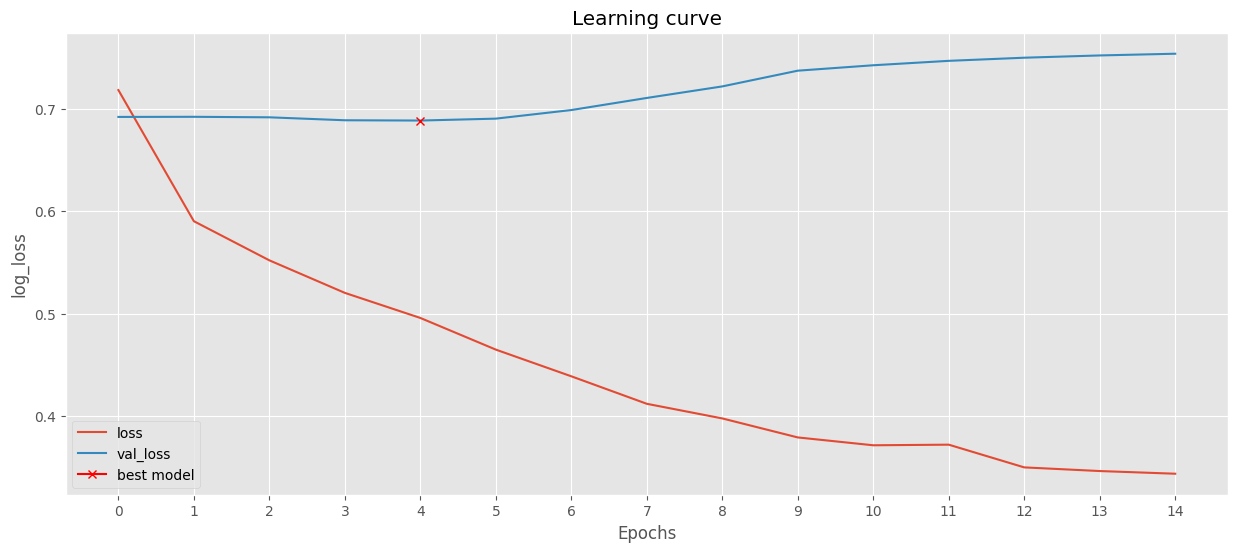

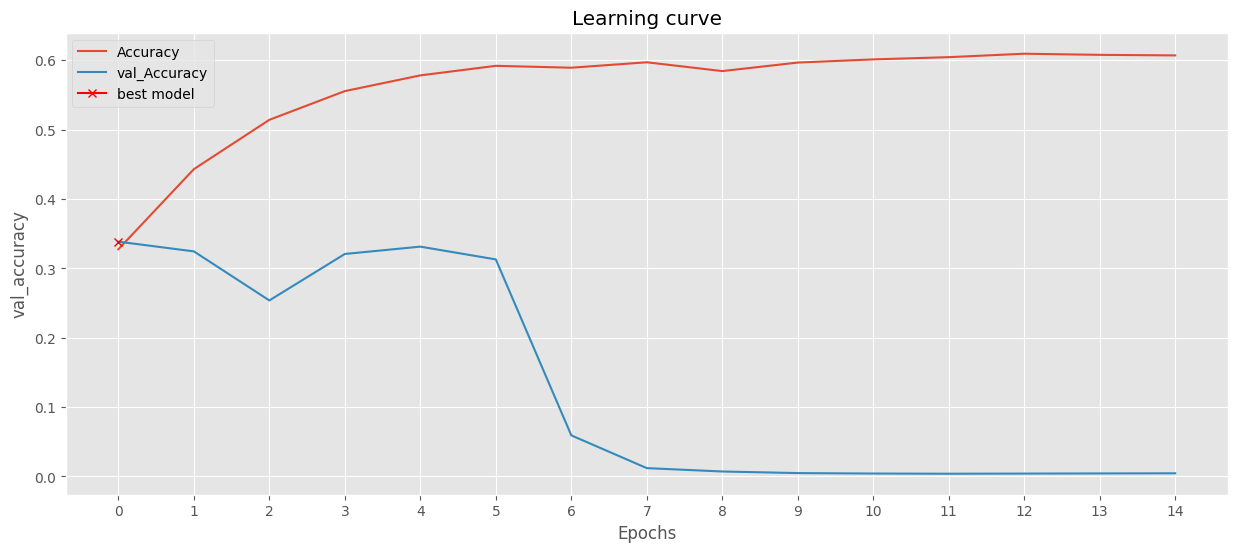

In [17]:
plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss") # 畫出訓練集的損失函數，並標示為 "loss"。
plt.plot(results.history["val_loss"], label="val_loss") # 畫出驗證集的損失函數，並標示為 "val_loss"。

## 在最佳驗證損失處標示一個紅色的 "x"，表示最佳模型的位置。
plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.xticks(results.epoch)
plt.legend(); # 在圖中添加圖例
plt.savefig('result/log_loss.png')

plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["accuracy"], label="Accuracy")
plt.plot(results.history["val_accuracy"], label="val_Accuracy")

plt.plot(np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("val_accuracy")
plt.xticks(results.epoch)
plt.legend(); 
plt.savefig('result/val_accuracy.png')

# **Inference**

In [19]:
model.load_weights('model/model-DenseUnet.h5')

In [20]:
model.evaluate(X_test, y_test, verbose=1)
# model.metrics_names

1/1 [==============================] - 4s 4s/step - loss: 0.6886 - accuracy: 0.3314 - mean_io_u: 1.0000 - auc: 0.7052 - precision: 0.6292 - recall: 0.6607 - sensitivity_at_specificity: 0.7893 - specificity_at_sensitivity: 0.5511


[0.6885974407196045,
 0.3313854932785034,
 1.0,
 0.7052430510520935,
 0.6291897892951965,
 0.6607258319854736,
 0.789257824420929,
 0.5511448979377747]

In [21]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_test = model.predict(X_test, verbose=1)

1/1 [==============================] - 1s 576ms/step


In [39]:
# Threshold predictions
preds_train_t = (preds_train > 0.55).astype(np.uint8)
preds_test_t = (preds_test > 0.55).astype(np.uint8)
print(preds_test.shape)
print(preds_test_t.shape)

(2, 640, 640, 1)
(2, 640, 640, 1)


In [23]:
from sklearn.metrics import classification_report


In [29]:
def plot_sample(X, y, preds, binary_preds, idx=None):
    """Function to plot the results"""
    if idx is None:
        idx = random.randint(0, len(X))

    has_mask = y[idx].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10)) # 建立子圖

    # 顯示原圖
    ax[0].imshow(X[idx, ..., 0], cmap='gray')
    if has_mask:
        ax[0].contour(y[idx].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Teeth Image')
    ax[0].set_axis_off()

    # 顯示 mask 照片
    ax[1].imshow(y[idx].squeeze(), cmap='gray')
    ax[1].set_title('Teeth Mask Image')
    ax[1].set_axis_off()

    # 顯示預測到的所有物件
    ax[2].imshow(preds[idx].squeeze(), cmap='gray', vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(preds[idx].squeeze(), colors='pink', levels=[0.5]) # change 
    ax[2].set_title('Teeth Image Predicted')
    ax[2].set_axis_off()
    
    # 顯示預測到的物件信心值高於 50%
    ax[3].imshow(binary_preds[idx].squeeze(), cmap='gray', vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(binary_preds[idx].squeeze(), colors='pink', levels=[0.5]) # change 
    ax[3].set_title('Teeth Mask Image Predicted binary')
    ax[3].set_axis_off()    

# **Predictions on training set**

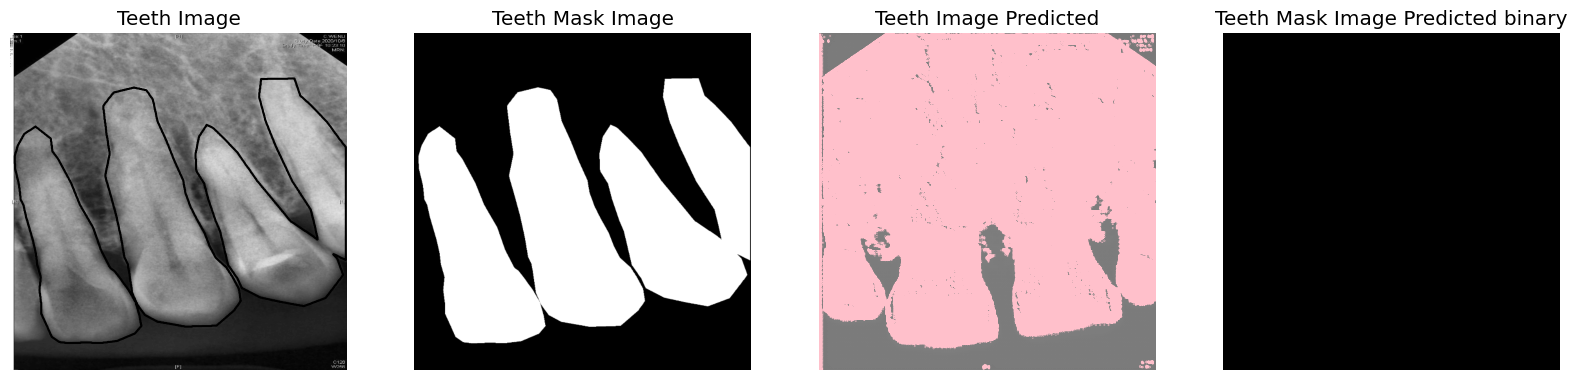

In [41]:
# Check if training data looks all right
plot_sample(X_test, y_test, preds_test, preds_test_t, idx=0)

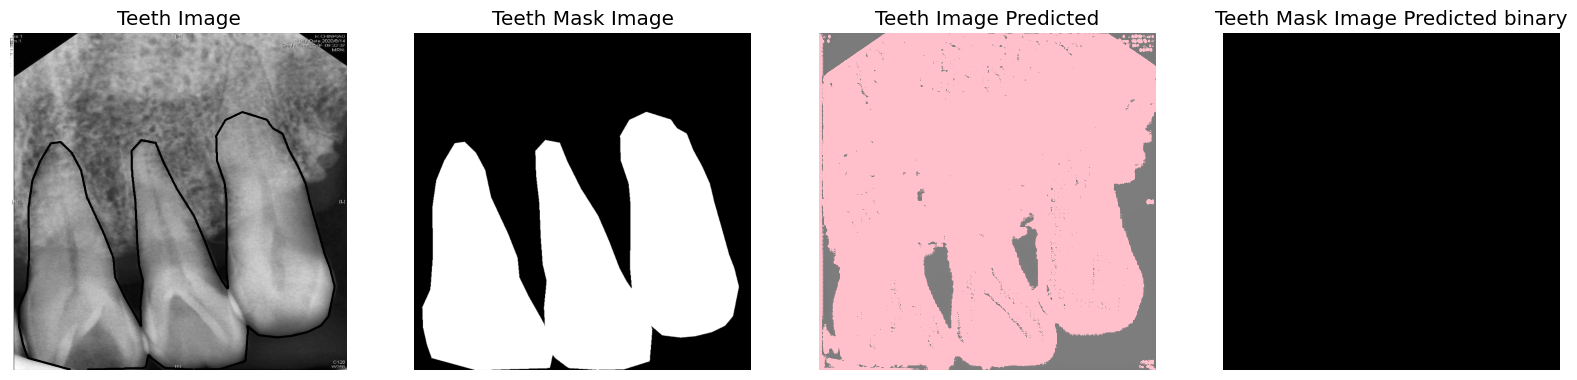

In [35]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

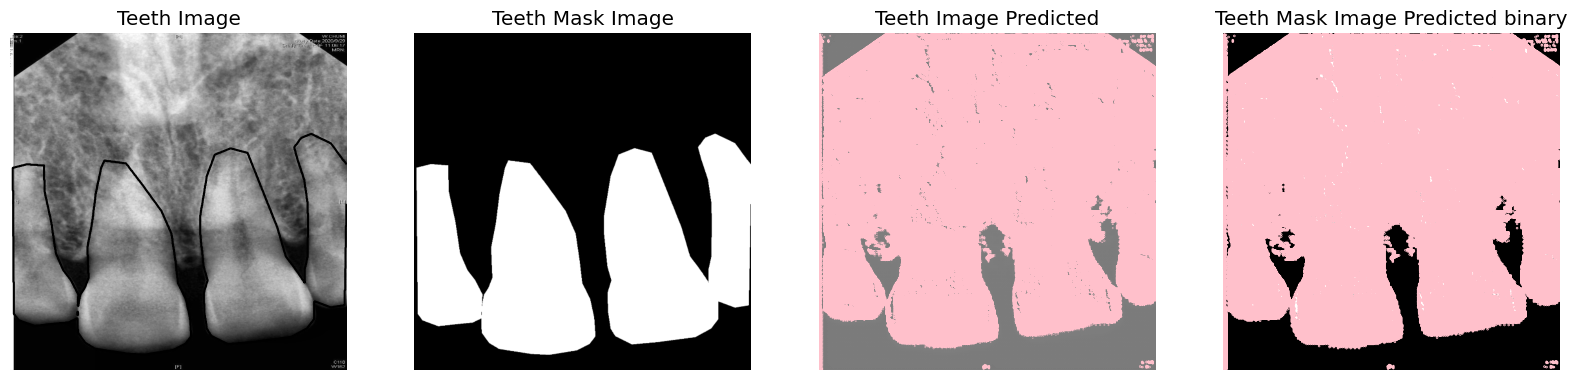

In [27]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

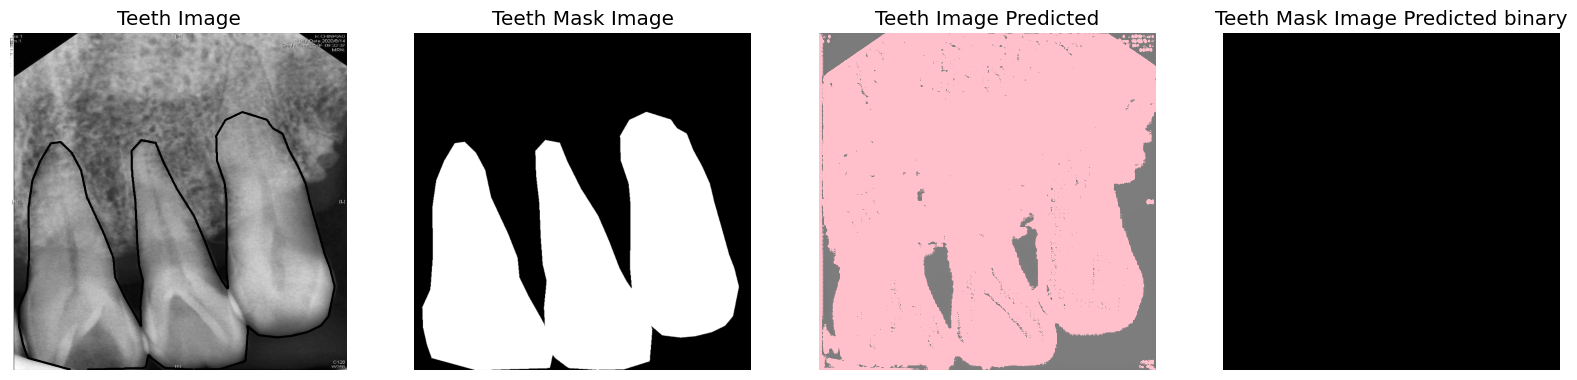

In [31]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

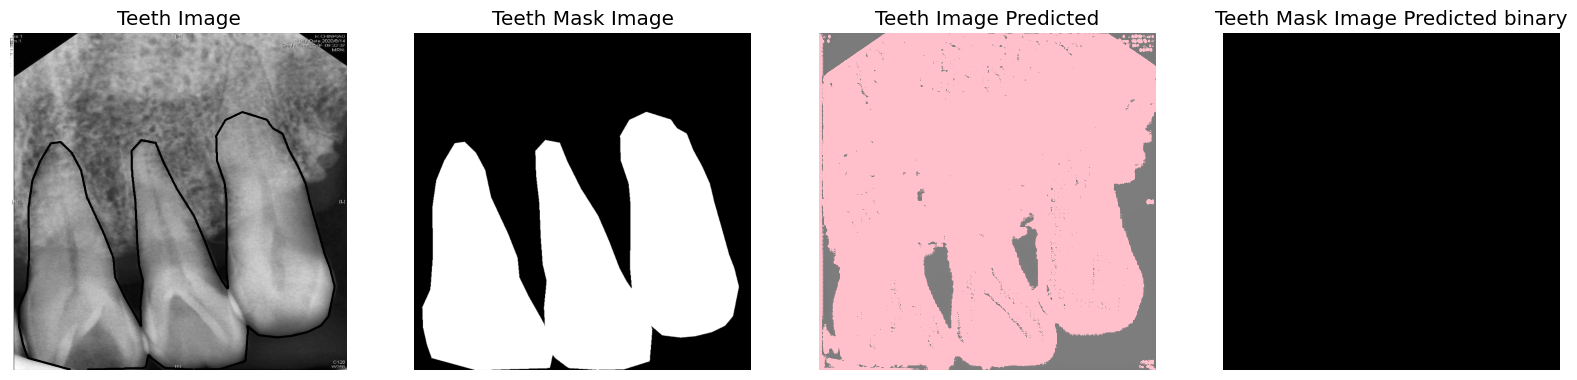

In [32]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

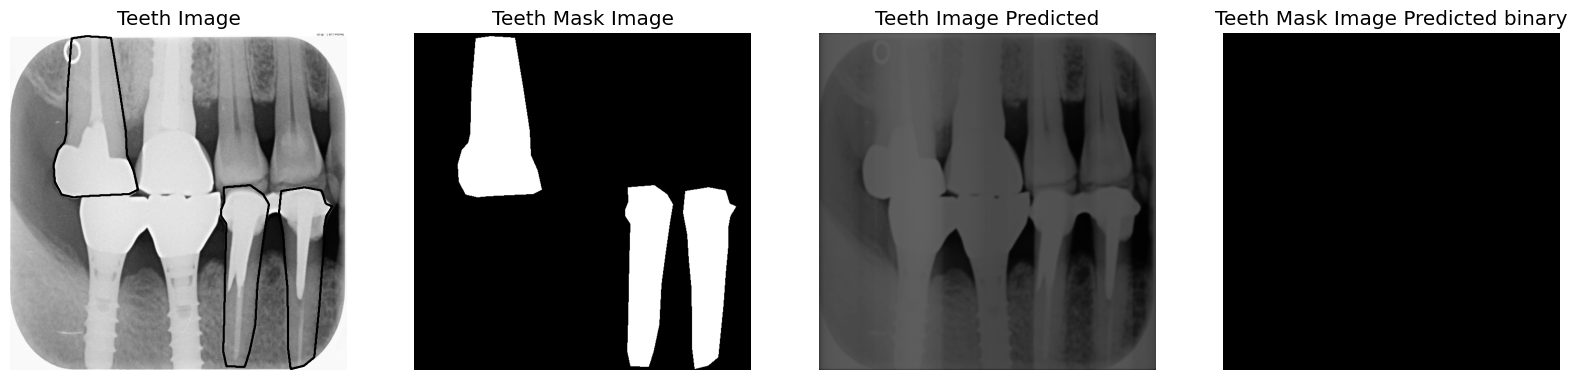

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)